In [1]:
import mlflow
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from mlflow.models import infer_signature

### Connect to mlflow

In [2]:
tracking_uri = "http://127.0.0.1:8080"
mlflow.set_tracking_uri(tracking_uri)

In [3]:
experiment_name = "churn_prediction"
artifact_loc = "data/churn_pred_models"
tags = {
    "mlflow.note.content": f"Customer churn prediction end-to-end pipeline using mlflow",
    "team": "AI engineering team",
    "project": f"churn_prediction_end_to_end project",
}

exp = mlflow.get_experiment_by_name(experiment_name)
if exp is None:
    mlflow.create_experiment(name=experiment_name, tags=tags, artifact_location=artifact_loc)
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

### Load dataset for training model


In [127]:
X_train = np.load("../data/X_train_scaled.npy")
X_test = np.load("../data/X_test_scaled.npy")
y_train = np.load("../data/y_train.npy", allow_pickle=True)
y_test = np.load("../data/y_test.npy", allow_pickle=True)

### Mlflow helper function

In [128]:
run_name = "churn_pred"

def mlflow_logging(params, metrics, model_name, sk_model):
    with mlflow.start_run(run_name=run_name, experiment_id=experiment_id):

        # Log to mlflow
        for key, val in params.items():
            mlflow.log_param(key=key, value=val)

        for key, val in metrics.items():
            mlflow.log_metric(key=key, value=val)

        tags = {
            "mlflow.note.content": f"{model_name} training outcome",
            "model_name": model_name
        }

        for key, val in tags.items():
            mlflow.set_tag(key=key, value=val)

        mlflow.sklearn.log_model(
            sk_model=sk_model, 
            input_example=X_test[:5],
            registered_model_name=f"{model_name}_models", 
            signature=infer_signature(X_train[:10], sk_model.predict(X_test[:5])),
            name=f"{model_name}_artifact",
        )
        
        print(f"✅ Done logging {model_name}")

In [129]:
rs = 42 # Random state

### Let's build out base model using decision tree

In [130]:
model_name = "decision_tree"

# Train out model
dtc_m1_params = {"max_depth":None, "criterion":'gini', "random_state":rs}
dtc_m1_model = DecisionTreeClassifier(**dtc_m1_params)

dtc_m1_model = dtc_m1_model.fit(X=X_train, y=y_train)
y_pred = dtc_m1_model.predict(X=X_test)

# Metrics
dtc_m1_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred)
}

print(dtc_m1_metrics)
# Logging to mlflow
mlflow_logging(dtc_m1_params, dtc_m1_metrics, model_name, dtc_m1_model)

{'accuracy': 0.8794772507260407, 'f1': 0.8880898876404495, 'recall': 0.946360153256705, 'precision': 0.8365791701947503}


Successfully registered model 'decision_tree_models'.
2025/09/21 22:39:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: decision_tree_models, version 1
Created version '1' of model 'decision_tree_models'.


✅ Done logging decision_tree
🏃 View run churn_pred at: http://127.0.0.1:8080/#/experiments/484940664715997483/runs/20b5d23544cc454397d3634283a64f44
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/484940664715997483


              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1022
           1       0.84      0.95      0.89      1044

    accuracy                           0.88      2066
   macro avg       0.89      0.88      0.88      2066
weighted avg       0.89      0.88      0.88      2066

ROC-AUC: 0.8787573760412684


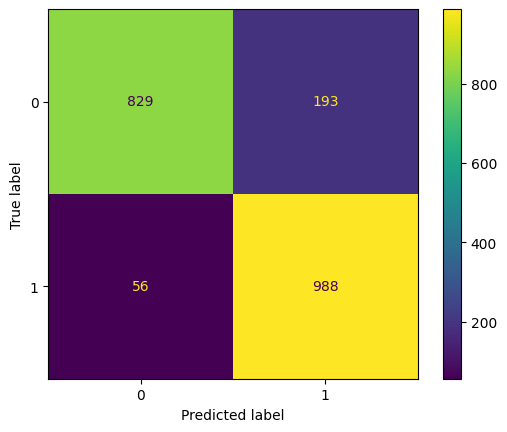

In [131]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc_m1_model.classes_)
disp.plot();

# Now let's fine tune hyperparametr and retrain

In [132]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

n_trials = 100

def objective(trial):
    # Suggest hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "criterion": trial.suggest_categorical("criterion", ["entropy", "gini"]),
        "random_state":rs
    }

    model = DecisionTreeClassifier(**params)
    model = model.fit(X=X_train, y=y_train)
    y_pred = model.predict(X=X_test)

    acc = accuracy_score(y_test, y_pred)

    return acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials, n_jobs=1)

In [133]:
dtc_m2_model = DecisionTreeClassifier(**study.best_params)
dtc_m2_model = dtc_m2_model.fit(X=X_train, y=y_train)
y_pred = dtc_m2_model.predict(X=X_test)

# Metrics
dtc_m2_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred)
}

print(dtc_m2_metrics)
# Logging to mlflow
mlflow_logging(study.best_params, dtc_m2_metrics, model_name, dtc_m2_model)

{'accuracy': 0.8741529525653436, 'f1': 0.8834080717488789, 'recall': 0.9434865900383141, 'precision': 0.8305227655986509}


Registered model 'decision_tree_models' already exists. Creating a new version of this model...
2025/09/21 22:39:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: decision_tree_models, version 2
Created version '2' of model 'decision_tree_models'.


✅ Done logging decision_tree
🏃 View run churn_pred at: http://127.0.0.1:8080/#/experiments/484940664715997483/runs/c037b68b56354929a29a3457dd8fa4a0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/484940664715997483


              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1022
           1       0.83      0.94      0.88      1044

    accuracy                           0.87      2066
   macro avg       0.88      0.87      0.87      2066
weighted avg       0.88      0.87      0.87      2066

ROC-AUC: 0.8734067001072198


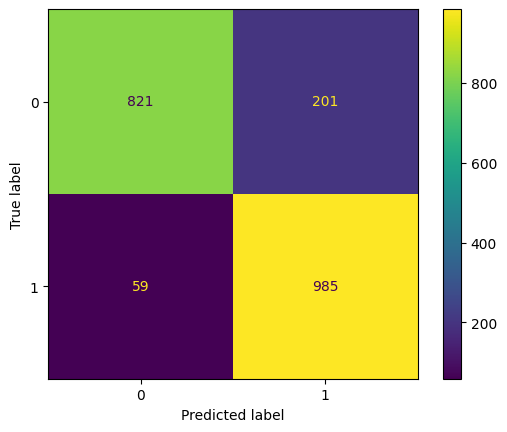

In [134]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc_m2_model.classes_)
disp.plot();

## Lets try random forest

In [135]:
from sklearn.ensemble import RandomForestClassifier

model_name = "random_forest"

rfc_m1_params = {
    "n_estimators":50, "criterion":"gini", "max_depth":10, "class_weight":'balanced_subsample', "random_state":rs
}

y_train_rev = y_train.ravel()
y_test_rev = y_test.ravel()

rfc_m1_model = RandomForestClassifier(**rfc_m1_params)
rfc_m1_model = rfc_m1_model.fit(X_train, y_train_rev)
y_pred = rfc_m1_model.predict(X_test)

# Metrics
rfc_m1_metrics = {
    "accuracy": accuracy_score(y_test_rev, y_pred),
    "f1": f1_score(y_test_rev, y_pred),
    "recall": recall_score(y_test_rev, y_pred),
    "precision": precision_score(y_test_rev, y_pred)
}

print(rfc_m1_metrics)
# Logging to mlflow
mlflow_logging(rfc_m1_metrics, rfc_m1_metrics, model_name, rfc_m1_model)

{'accuracy': 0.8407550822846079, 'f1': 0.8533214444939813, 'recall': 0.9166666666666666, 'precision': 0.7981651376146789}


Successfully registered model 'random_forest_models'.
2025/09/21 22:40:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random_forest_models, version 1
Created version '1' of model 'random_forest_models'.


✅ Done logging random_forest
🏃 View run churn_pred at: http://127.0.0.1:8080/#/experiments/484940664715997483/runs/442bb5efdee643b39e13c012631efead
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/484940664715997483


              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1022
           1       0.80      0.92      0.85      1044

    accuracy                           0.84      2066
   macro avg       0.85      0.84      0.84      2066
weighted avg       0.85      0.84      0.84      2066

ROC-AUC: 0.8399380300065231


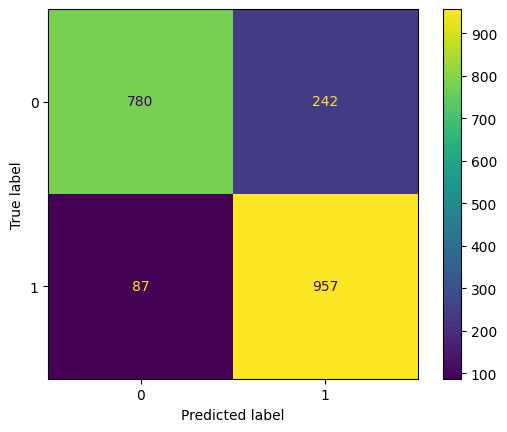

In [136]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_m1_model.classes_)
disp.plot();

## Let's optimize the hyperparameters 

In [137]:
def objective(trial):
    # Suggest hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "n_estimators": trial.suggest_int("n_estimators", 10, 150),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "criterion": trial.suggest_categorical("criterion", ["entropy", "gini", "log_loss"]),
        "random_state":rs
    }

    model = RandomForestClassifier(**params)
    model = model.fit(X_train, y_train_rev)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test_rev, y_pred)

    return acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials, n_jobs=1)

In [138]:
rfc_m2_model = RandomForestClassifier(**study.best_params)
rfc_m2_model = rfc_m2_model.fit(X=X_train, y=y_train_rev)
y_pred = rfc_m2_model.predict(X=X_test)

# Metrics
rfc_m2_metrics = {
    "accuracy": accuracy_score(y_test_rev, y_pred),
    "f1": f1_score(y_test_rev, y_pred),
    "recall": recall_score(y_test_rev, y_pred),
    "precision": precision_score(y_test_rev, y_pred)
}

print(rfc_m2_metrics)
# Logging to mlflow
mlflow_logging(study.best_params, rfc_m2_metrics, model_name, rfc_m2_model)

{'accuracy': 0.888189738625363, 'f1': 0.8970129291127954, 'recall': 0.9636015325670498, 'precision': 0.8390325271059216}


Registered model 'random_forest_models' already exists. Creating a new version of this model...
2025/09/21 22:41:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random_forest_models, version 2
Created version '2' of model 'random_forest_models'.


✅ Done logging random_forest
🏃 View run churn_pred at: http://127.0.0.1:8080/#/experiments/484940664715997483/runs/78522b41d6d84ed483c0697090aeba8d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/484940664715997483


              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1022
           1       0.84      0.96      0.90      1044

    accuracy                           0.89      2066
   macro avg       0.90      0.89      0.89      2066
weighted avg       0.90      0.89      0.89      2066

ROC-AUC: 0.8873780656964407


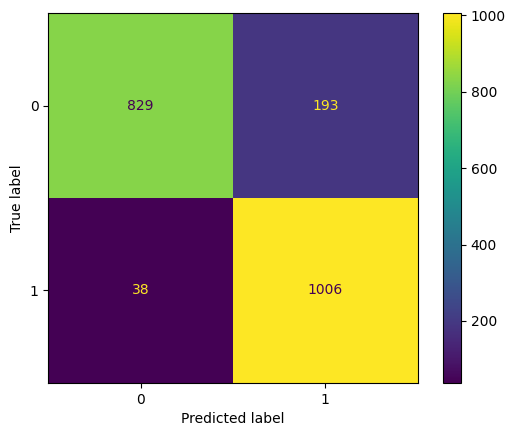

In [139]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_m2_model.classes_)
disp.plot();

## Let's try DNN - LSTM

In [140]:
# reshape to (samples, timesteps=1, features)
X_train_lstm = np.expand_dims(X_train, axis=1)
X_test_lstm = np.expand_dims(X_test, axis=1)

print(X_train_lstm.shape, X_test_lstm.shape)

(8260, 1, 19) (2066, 1, 19)


In [142]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=(1, X_train.shape[1]), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train_lstm, y_train, epochs=80, batch_size=50, validation_split=0.2, verbose=1)


Epoch 1/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7368 - loss: 0.5505 - val_accuracy: 0.7603 - val_loss: 0.4945
Epoch 2/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7573 - loss: 0.4949 - val_accuracy: 0.7651 - val_loss: 0.4872
Epoch 3/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7613 - loss: 0.4910 - val_accuracy: 0.7651 - val_loss: 0.4824
Epoch 4/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7620 - loss: 0.4888 - val_accuracy: 0.7676 - val_loss: 0.4810
Epoch 5/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7594 - loss: 0.4903 - val_accuracy: 0.7694 - val_loss: 0.4818
Epoch 6/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7621 - loss: 0.4859 - val_accuracy: 0.7651 - val_loss: 0.4824
Epoch 7/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7642 - loss: 0.4840 - val_accuracy: 0.7651 - val_loss: 0.4791
Epoch 8/80
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7636 - loss: 0.4841 - val_accuracy: 0.